## Move Evaluation and ELO Rating Dynamic with Kalman — CLEAN RESET (CSV BASED)

- STEP 1 — IMPORTS & CONFIG

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import chess
from stockfish import Stockfish
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-darkgrid")

# Change paths
STOCKFISH_PATH = "./stockfish-windows-x86-64-avx2/stockfish/stockfish-windows-x86-64-avx2.exe"
CSV_PATH = "output.csv" # After preprocessing

- Load Dataset (Polars → Pandas)

In [2]:
# Fast load using Polars
df_pl = pl.read_csv(CSV_PATH)
print(f"✅ Loaded {df_pl.height:,} rows using Polars.")

# Convert to Pandas for iterative Stockfish analysis
df = df_pl.to_pandas()
print(f"✅ Converted to Pandas ({len(df)} rows).")

df.head()

✅ Loaded 91,178 rows using Polars.
✅ Converted to Pandas (91178 rows).


,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Winner,Moves,avg_elo,elo_cat
0,Rated Standard game,breves,riiton,1-0,1227,1190,11,-17,C26,White,1. e4 e5 2. Bc4 Nf6 3. Nc3 a6 4. Nf3 b5 5. Bd5...,1208.5,1200-1399
1,Rated Standard game,mironi,grimshanky,0-1,1599,1582,-11,12,C20,Black,1. e4 e5 2. d3 c5 3. c4 Be7 4. Nc3 Nf6 5. h3 d...,1590.5,1400-1599
2,Rated Standard game,foss2015,fortune-kook,0-1,1519,1479,-13,12,A45,Black,1. d4 Nf6 2. Nc3 e6 3. Bf4 d5 4. h3 c5 5. e4 Q...,1499.0,1400-1599
3,Rated Standard game,LittleCartier,vilassarxavi,0-1,1315,1371,-9,9,C40,Black,1. e4 e5 2. Nf3 f5 3. exf5 Nf6 4. Nxe5 d6 5. N...,1343.0,1200-1399
4,Rated Standard game,CRNI75,zaharof2010,1-0,1589,1329,4,-6,C40,White,1. e4 e5 2. Nf3 Qf6 3. Nc3 Be7 4. d4 d6 5. d5 ...,1459.0,1400-1599


- Initialize Stockfish

In [3]:
stockfish = Stockfish(path=STOCKFISH_PATH)
print(f"✅ Stockfish {stockfish.get_stockfish_major_version()} initialized.")


✅ Stockfish 17 initialized.


- Evaluate a Single Game (White + Black CPL)

In [4]:
def evaluate_game_from_row(row, stockfish, depth=8, verbose=False):
    """
    Evaluate a single chess game using Stockfish.
    Returns move-level CPL for both players + engine best moves (UCI).
    """
    board = chess.Board()
    moves_raw = str(row["Moves"]).replace("\n", " ").split(" ")
    results = []

    skip_tokens = {"1-0", "0-1", "1/2-1/2"}

    for i, move_text in enumerate(moves_raw):
        move_text = move_text.strip()
        if not move_text or move_text.endswith(".") or move_text in skip_tokens:
            continue

        player = "White" if board.turn == chess.WHITE else "Black"

        # --- Best move & evaluation before player's move ---
        stockfish.set_fen_position(board.fen())
        best_move_uci = stockfish.get_best_move()
        best_eval = stockfish.get_evaluation()
        best_eval_cp = (
            best_eval["value"] if best_eval["type"] == "cp"
            else 10000 if best_eval["value"] > 0 else -10000
        )

        # --- Parse and apply player's move ---
        try:
            move = board.parse_san(move_text)
        except Exception as e:
            if verbose:
                print(f"⚠️ Invalid SAN move skipped: {move_text} ({e})")
            continue

        board.push(move)

        # --- Evaluate new position ---
        stockfish.set_fen_position(board.fen())
        after_eval = stockfish.get_evaluation()
        after_eval_cp = (
            after_eval["value"] if after_eval["type"] == "cp"
            else 10000 if after_eval["value"] > 0 else -10000
        )

        # --- Compute CPL ---
        if player == "White":
            actual_eval = -after_eval_cp
            cpl_white = best_eval_cp - actual_eval
            cpl_black = np.nan
        else:
            actual_eval = after_eval_cp
            cpl_black = best_eval_cp + actual_eval
            cpl_white = np.nan

        results.append({
            "move_number": i + 1,
            "player": player,
            "player_move_UCI": move.uci(),
            "best_move_UCI": best_move_uci,
            "CPL_White": cpl_white,
            "CPL_Black": cpl_black
        })

    df_eval = pd.DataFrame(results)
    if verbose:
        print(f"✅ Evaluated {len(df_eval)} valid moves for {row['White']} vs {row['Black']}")
    return df_eval


- Kalman Filter for Smooth Evaluation

In [5]:
def apply_kalman_filter(cpl_values, R=50, Q=10):
    """
    Smooths a 1D CPL series using a Kalman filter.
    R = measurement noise (Stockfish evaluation variance)
    Q = transition noise (player performance variance)
    """
    values = np.array(cpl_values.dropna(), dtype=float)
    if len(values) == 0:
        return np.array([])

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=values[0],
        observation_covariance=R,
        transition_covariance=Q
    )
    state_means, _ = kf.filter(values)
    return state_means.flatten()


- Dynamic ELO Estimation

In [6]:
def compute_dynamic_elo(df_eval, row):
    """
    Compute Kalman-smoothed CPL → ELO estimates.
    Cleans, interpolates, and splits output into White/Black dataframes.
    """
    # --- Apply Kalman filters ---
    df_eval["Kalman (White)"] = apply_kalman_filter(df_eval["CPL_White"].fillna(0))
    df_eval["Kalman (Black)"] = apply_kalman_filter(df_eval["CPL_Black"].fillna(0))

    # --- ELO progression estimation ---
    white_start = int(row["WhiteElo"])
    black_start = int(row["BlackElo"])

    df_eval["White ELO est"] = white_start + (df_eval["Kalman (White)"] / 10)
    df_eval["Black ELO est"] = black_start + (df_eval["Kalman (Black)"] / 10)

    # --- Cleanup ---
    drop_cols = ["best_eval_cp", "after_eval_cp", "White ELO final (Actual)", "Black ELO final (Actual)"]
    df_eval.drop(columns=[c for c in drop_cols if c in df_eval.columns], inplace=True, errors="ignore")

    df_eval.interpolate(method="linear", inplace=True)
    df_eval.bfill(inplace=True)
    df_eval.ffill(inplace=True)
    df_eval = df_eval.round(2)

    # --- Split by player ---
    df_white = df_eval[df_eval["player"] == "White"].drop(
        columns=["CPL_Black", "Kalman (Black)", "Black ELO est"], errors="ignore"
    ).reset_index(drop=True)

    df_black = df_eval[df_eval["player"] == "Black"].drop(
        columns=["CPL_White", "Kalman (White)", "White ELO est"], errors="ignore"
    ).reset_index(drop=True)

    return df_white, df_black


# Run for a Sample Game

In [7]:
sample_row = df.iloc[0]
sample_row

Event                                            Rated Standard game
White                                                         breves
Black                                                         riiton
Result                                                           1-0
WhiteElo                                                        1227
BlackElo                                                        1190
WhiteRatingDiff                                                   11
BlackRatingDiff                                                  -17
ECO                                                              C26
Winner                                                         White
Moves              1. e4 e5 2. Bc4 Nf6 3. Nc3 a6 4. Nf3 b5 5. Bd5...
avg_elo                                                       1208.5
elo_cat                                                    1200-1399
Name: 0, dtype: object

In [8]:
df_eval = evaluate_game_from_row(sample_row, stockfish)

In [9]:
df_eval.head(6)

,move_number,player,player_move_UCI,best_move_UCI,CPL_White,CPL_Black
0,2,White,e2e4,e2e4,72.0,NaN
1,3,Black,e7e5,e7e5,NaN,79.0
2,5,White,f1c4,g1f3,32.0,NaN
3,6,Black,g8f6,g8f6,NaN,1.0
4,8,White,b1c3,d2d3,14.0,NaN
5,9,Black,a7a6,f8c5,NaN,72.0


In [10]:
df_white, df_black = compute_dynamic_elo(df_eval, sample_row)

C:\Users\Unal\AppData\Local\Temp\ipykernel_29408\3042659471.py:21: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_eval.interpolate(method="linear", inplace=True)


In [11]:
df_white.head()

,move_number,player,player_move_UCI,best_move_UCI,CPL_White,Kalman (White),White ELO est
0,2,White,e2e4,e2e4,72.0,72.00,1234.20
1,5,White,f1c4,g1f3,32.0,51.59,1232.16
2,8,White,b1c3,d2d3,14.0,27.77,1229.78
3,11,White,g1f3,g1f3,127.0,56.76,1232.68
4,14,White,c4d5,c4b3,50.0,41.32,1231.13


In [12]:
df_black.head()

,move_number,player,player_move_UCI,best_move_UCI,CPL_Black,Kalman (Black),Black ELO est
0,3,Black,e7e5,e7e5,79.0,14.23,1191.42
1,6,Black,g8f6,g8f6,1.0,7.31,1190.73
2,9,Black,a7a6,f8c5,72.0,28.45,1192.85
3,12,Black,b7b5,b8c6,136.0,60.36,1196.04
4,15,Black,c7c6,f6d5,30.0,35.63,1193.56


## Visualization

- ELO Progression Plot : Shows both players’ estimated ELO over the course of the game.

In [13]:
def plot_elo_progress(df_white, df_black, row):
    plt.figure(figsize=(10,6))
    plt.plot(df_white["move_number"], df_white["White ELO est"], "-o", color="deepskyblue", label=f"{row['White']} (White)")
    plt.plot(df_black["move_number"], df_black["Black ELO est"], "-o", color="salmon", label=f"{row['Black']} (Black)")

    plt.title(f"ELO Progression: {row['White']} vs {row['Black']}")
    plt.xlabel("Move #")
    plt.ylabel("Estimated ELO")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


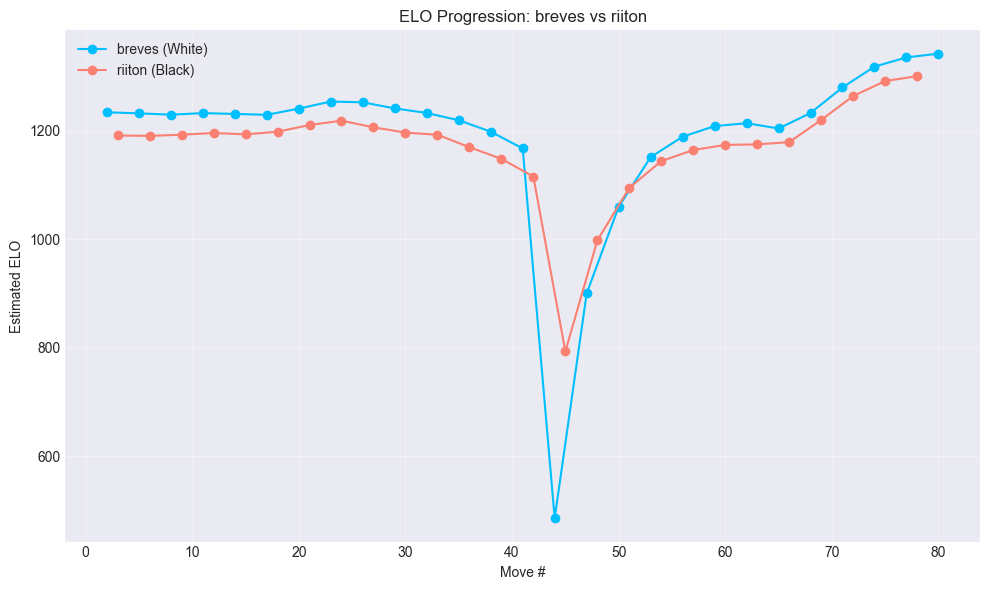

In [14]:
plot_elo_progress(df_white, df_black, sample_row)

- CPL Trend Plot : Visualizes how precisely each player plays over time (lower CPL = better moves).

In [15]:
def plot_cpl_trend(df_white, df_black, row):
    plt.figure(figsize=(10,6))
    plt.plot(df_white["move_number"], df_white["CPL_White"], "-o", color="royalblue", label="White CPL")
    plt.plot(df_black["move_number"], df_black["CPL_Black"], "-o", color="firebrick", label="Black CPL")

    plt.title(f"Centipawn Loss (CPL) Over Time: {row['White']} vs {row['Black']}")
    plt.xlabel("Move #")
    plt.ylabel("Centipawn Loss (CPL)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


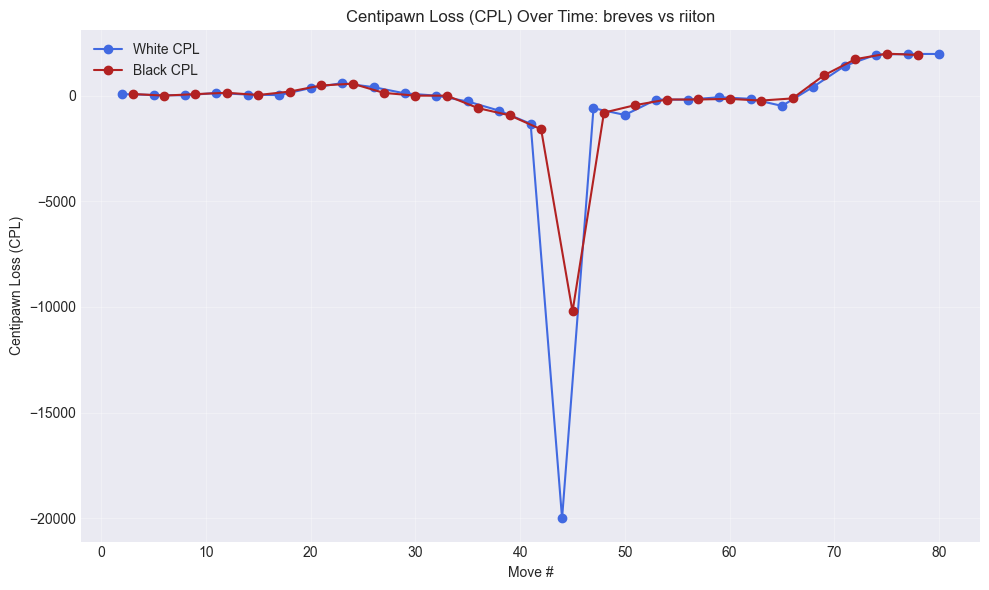

In [24]:
plot_cpl_trend(df_white, df_black, sample_row)


# How actual ELO correlates with the sequence of engine evaluations.

In [25]:
# TODO :: Now I need to calculate the ELO score according to the player's actions,

In [16]:
import multiprocessing as mp
import os

CSV_PATH = "output.csv"
OUTPUT_DIR = "features_fast"
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_JOBS = max(1, mp.cpu_count() - 1)  # use all cores but one
BATCH_SIZE = 10    # games per batch
MAX_GAMES = 50     # process only N games for now
MAX_MOVES = 12     # only first 12 moves per game
STOCKFISH_DEPTH = 6  # engine search depth (lower = faster)

print(f"✅ Config: {N_JOBS} cores, depth={STOCKFISH_DEPTH}, moves={MAX_MOVES}")


✅ Config: 15 cores, depth=6, moves=12


In [17]:
stockfish = Stockfish(
    path=STOCKFISH_PATH,
    parameters={
        "Threads": 2,
        "Hash": 64,
        "UCI_LimitStrength": False,
    }
)

stockfish.set_depth(STOCKFISH_DEPTH)
print(f"✅ Stockfish loaded (depth={STOCKFISH_DEPTH})")

✅ Stockfish loaded (depth=6)
